In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pathlib import Path

from pandas import testing as tm

import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import shap

import math

from lib import *

In [63]:
pd.options.display.float_format = '{:,.2f}'.format
# plt.style.use('dark_background')
sns.set_theme(style="whitegrid", palette="muted")
sns.color_palette()

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [64]:
WORK_DIR = 'working_data'
FILE_NAME = 'df_work_ds_final.zip'

In [65]:
filepath = Path(f'./{WORK_DIR}/{FILE_NAME}')
df = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [66]:
columns_drop = [
    "Fel_1",
    "Fel_2",
    "D_SL",
    "O2_tot",
    "Sl_tot",
    "AC_rbk_open",
    "AC_valve_open",
    "P_O2_in",
    # "P_tot_2",
    "FT1_level",
    "FT1_P",
    "FT1_T_in",
    "FT1_T",
    "FT2_level",
    "FT2_P",
    "FT2_T",
    "Cond_Q",
    "Cond_level",
    "Cond_valve",
    "O2_conc_1",
    "O2_conc_2",
    'T_C1',
    'T_C2',
    'T_C3',
    'T_C4',
    'T_C5'
]

df.drop(columns_drop, inplace=True, axis=1)

In [67]:
# df['Fe2+'] = df['Fe2+'].shift(2)

# df.dropna(axis=0, inplace=True)

#df['lag_1'] = df['Fe2+'].shift(1)
#df['lag_2'] = df['Fe2+'].shift(2)
#df['lag_3'] = df['Fe2+'].shift(3)
#df['lag_4'] = df['Fe2+'].shift(4)
#df['lag_5'] = df['Fe2+'].shift(5)

#df.dropna(axis=0, inplace=True)

In [68]:
X = df.drop(['Fe2+'], axis=1)
y = df['Fe2+']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=False)

In [70]:
for col in X_train.columns:
    smooth_data_moving_average(X_train[col], window=12)

smooth_data_moving_average(y_train, window=12)

for col in X_test.columns:
   smooth_data_moving_average(X_test[col], window=12)

smooth_data_moving_average(y_test, window=12)

In [71]:
clf = make_pipeline(
    StandardScaler(),
    # ElasticNet(l1_ratio=1)
    Ridge()
)

Метрики качества
RMSE: 0.6338
MAE: 0.4857
R2: -1.0511


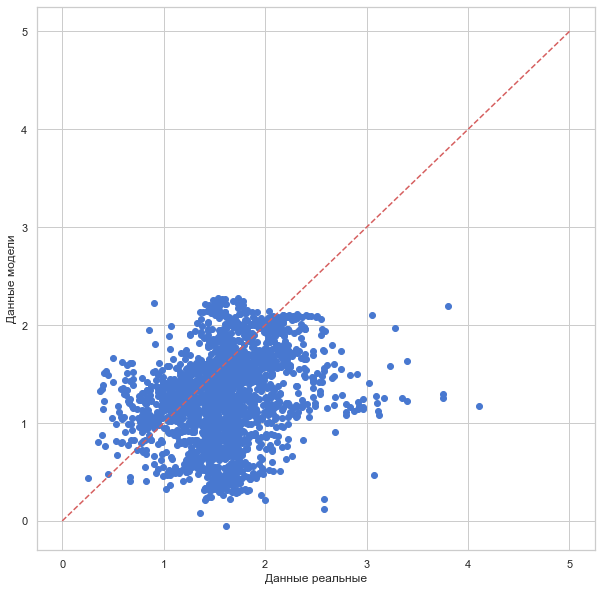

In [72]:
clf.fit(X_train, y_train)
model_score(clf, X_test, y_test)

In [73]:
train_data = cb.Pool(X_train, y_train)
test_data = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function='RMSE')
model.fit(train_data)

Learning rate set to 0.057923
0:	learn: 0.5036795	total: 42.5ms	remaining: 42.4s
1:	learn: 0.4887818	total: 63.5ms	remaining: 31.7s
2:	learn: 0.4738743	total: 77.4ms	remaining: 25.7s
3:	learn: 0.4608632	total: 90.5ms	remaining: 22.5s
4:	learn: 0.4483516	total: 104ms	remaining: 20.7s
5:	learn: 0.4372303	total: 118ms	remaining: 19.5s
6:	learn: 0.4260394	total: 131ms	remaining: 18.6s
7:	learn: 0.4155594	total: 142ms	remaining: 17.6s
8:	learn: 0.4064778	total: 154ms	remaining: 17s
9:	learn: 0.3982547	total: 171ms	remaining: 17s
10:	learn: 0.3902867	total: 187ms	remaining: 16.8s
11:	learn: 0.3832910	total: 200ms	remaining: 16.5s
12:	learn: 0.3766494	total: 212ms	remaining: 16.1s
13:	learn: 0.3703458	total: 222ms	remaining: 15.6s
14:	learn: 0.3645614	total: 233ms	remaining: 15.3s
15:	learn: 0.3594066	total: 246ms	remaining: 15.1s
16:	learn: 0.3539219	total: 257ms	remaining: 14.8s
17:	learn: 0.3493742	total: 270ms	remaining: 14.7s
18:	learn: 0.3444836	total: 283ms	remaining: 14.6s
19:	learn: 

Метрики качества
RMSE: 0.5237
MAE: 0.4156
R2: -0.4003


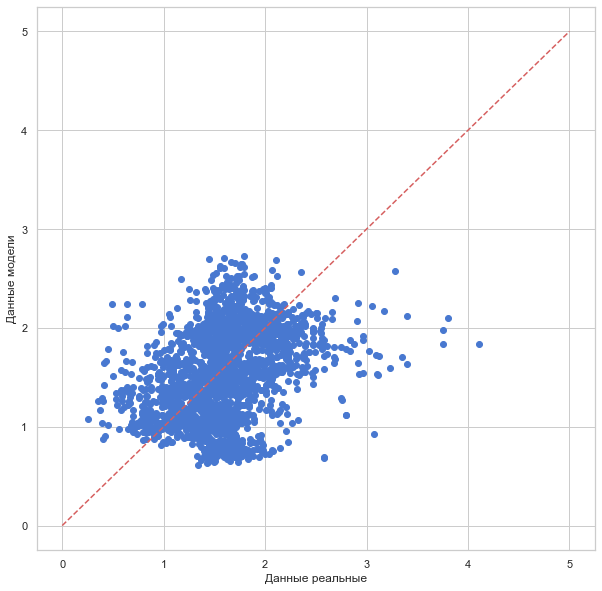

In [74]:
model_score(model, X_test, y_test)

In [75]:
pred_lm = clf.predict(X_test)
pred_cb = model.predict(X_test)

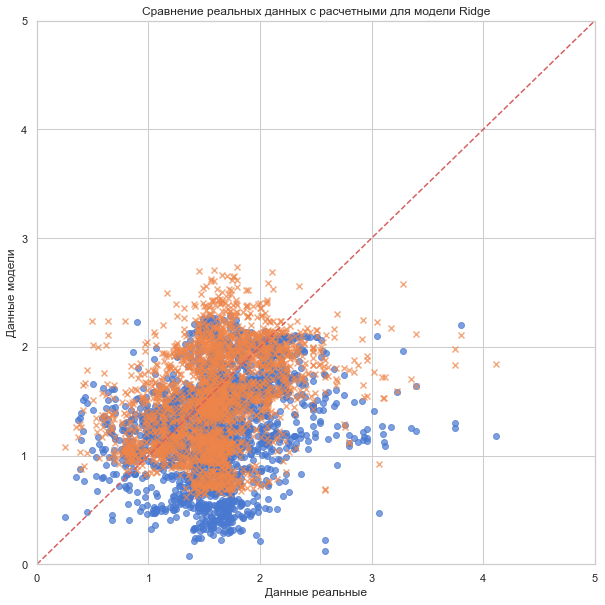

In [76]:
fig, main_ax = plt.subplots(figsize=(10, 10))

main_ax.scatter(y_test.values, pred_lm, alpha=0.7)
main_ax.scatter(y_test.values, pred_cb, marker='x', alpha=0.7)
scale = math.ceil(max(y_test.values.max(), pred_lm.max()))
main_ax.plot([0, scale], [0, scale], 'r--')

main_ax.set_xlim(0, scale)
main_ax.set_ylim(0, scale)

main_ax.set_title("Сравнение реальных данных с расчетными для модели Ridge")
main_ax.set_xlabel("Данные реальные")
main_ax.set_ylabel("Данные модели")

# ins_ax = fig.add_axes([0.64, 0.15, 0.25, 0.25])
# ins_ax.scatter(y_test.values, pred_lm, alpha=0.7)
# ins_ax.scatter(y_test.values, pred_cb, marker='x', alpha=0.7)
# ins_ax.set_xlim(0, 4)
# ins_ax.set_ylim(0, 4)
# ins_ax.plot([0, 4], [0, 4], 'r--')

plt.show()

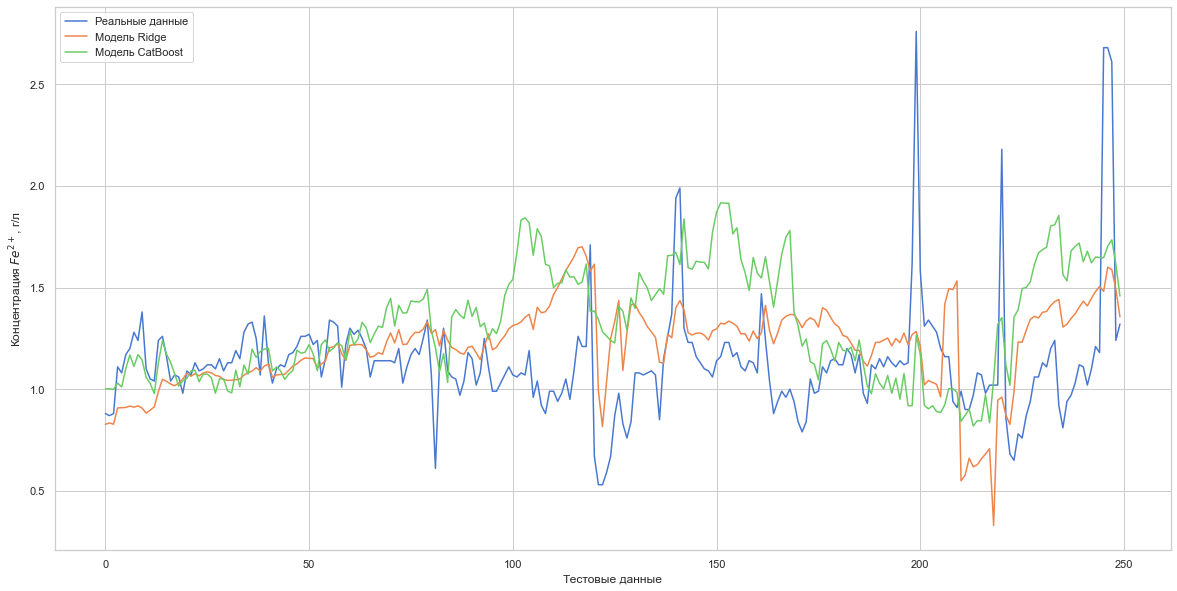

In [77]:
plt.figure(figsize=(20,10))

start = 1000
end = 1250

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred_lm[start:end], label='Модель Ridge')
plt.plot(pred_cb[start:end], label='Модель CatBoost')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

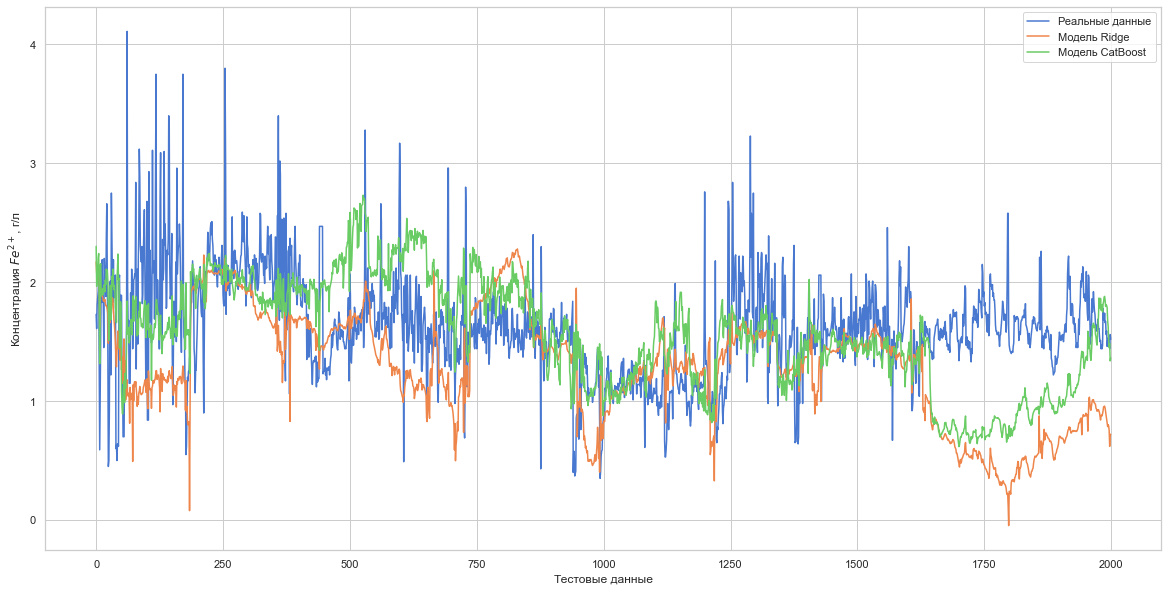

In [78]:
plt.figure(figsize=(20,10))

start = 0
end = 2000

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred_lm[start:end], label='Модель Ridge')
plt.plot(pred_cb[start:end], label='Модель CatBoost')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();